# **Project: PES Construction and DFT-Based Adsorption Study of H₂ on Ni(111)**

**Objective:**  
This project aims to construct the potential energy surface (PES) for the adsorption of a hydrogen molecule (H₂) on a Ni(111) surface using Density Functional Theory (DFT) calculations. The ultimate goal is to analyze adsorption behavior, determine energy minima, and visualize the PES curve.

**Outline:**  
1. Structure generation for H₂ at varying distances above the Ni(111) surface  
2. DFT calculations using GPAW for each structure  
3. Extraction of total energies  
4. Calculation of adsorption energies using slab and gas-phase references  
5. PES curve plotting and interpretation


## 1. Structure Generation: H₂ on Ni(111)

We begin by generating a series of geometries where a hydrogen molecule (H₂) is placed above a Ni(111) slab at different distances. These geometries will later be used for DFT calculations.

- The Ni(111) slab is created using ASE's `fcc111` builder.
- H₂ molecule is positioned vertically above the surface.
- Several `.traj` files are created, each representing a different height.

The resulting structures represent the configuration space to be sampled for constructing the PES.


In [3]:
from ase.io import read, write
from ase.build import fcc111
from ase import Atoms
import os

# Create Ni(111) slab
slab = fcc111('Ni', size=(3, 3, 3), vacuum=10.0)
write('ni111.traj', slab)

# Define H2 molecule
h2 = Atoms('H2', positions=[[0, 0, 0], [0, 0, 0.74]])

# Find center above the slab
x_center = slab.get_cell()[0, 0] / 2
y_center = slab.get_cell()[1, 1] / 2
z_slab_top = slab.get_positions()[:, 2].max()

# Heights to sample
heights = [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0,
           3.5, 4.0, 5.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0]

# Generate structures
for h in heights:
    fname = f'h2_{h:.1f}.traj'
    if os.path.exists(fname):
        continue
    h2_copy = h2.copy()
    h2_copy.translate([x_center, y_center, z_slab_top + h])
    combined = slab + h2_copy
    write(fname, combined)
    print(f'Generated: {fname}')


Generated: h2_2.5.traj


This code reads each previously generated H₂+slab structure and performs a DFT calculation using GPAW.
The total energy is printed and also written into a `.txt` file (like `calc_2.5.txt`) for further analysis.

💡 These energies are later used in adsorption energy and PES calculations.


### 2. DFT Energy Calculations for H₂ + Ni(111) Systems

In this step, we calculated the total energies of the H₂ molecule adsorbed at various distances above the Ni(111) surface using DFT.

For each `.traj` structure generated in the previous step, we used GPAW with the following setup:
- Plane-wave basis set (`PW(400)`)
- PBE exchange-correlation functional (`xc='PBE'`)
- K-point grid of `(2, 2, 1)`

The total energies were saved in corresponding text files named `calc_*.txt`, and will later be used to compute the adsorption energy profile.


In [ ]:
from ase.io import read
from gpaw import GPAW, PW

# Heights for which the geometries were generated
heights = [0.8, 1.0, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0,
           2.2, 2.4, 2.5, 2.6, 2.8, 3.0, 3.5, 4.0, 5.0, 6.0, 7.0,
           9.0, 11.0, 13.0, 15.0, 17.0, 19.0]

for h in heights:
    fname = f'h2_{h:.1f}.traj'
    atoms = read(fname)

    # Define GPAW calculator
    calc = GPAW(mode=PW(400), xc='PBE', kpts=(2, 2, 1), txt=f'calc_{h:.1f}.txt')
    atoms.calc = calc

    # Calculate total energy
    energy = atoms.get_potential_energy()
    print(f'{fname}: {energy:.6f} eV')


### 3. Adsorption Energy Calculation and PES Plotting

In this step, we calculate the adsorption energy of the H₂ molecule at various distances above the Ni(111) surface. 

The adsorption energy is defined as:

\[
E_{ads} = E_{H_2+slab} - (E_{slab} + E_{H_2})
\]

Where:
- \(E_{H_2+slab}\): Total energy of the combined system at each height
- \(E_{slab}\): Reference energy of the isolated Ni(111) slab
- \(E_{H_2}\): Reference energy of the gas-phase H₂ molecule

The calculated adsorption energies are then normalized and plotted to obtain the potential energy surface (PES) profile.


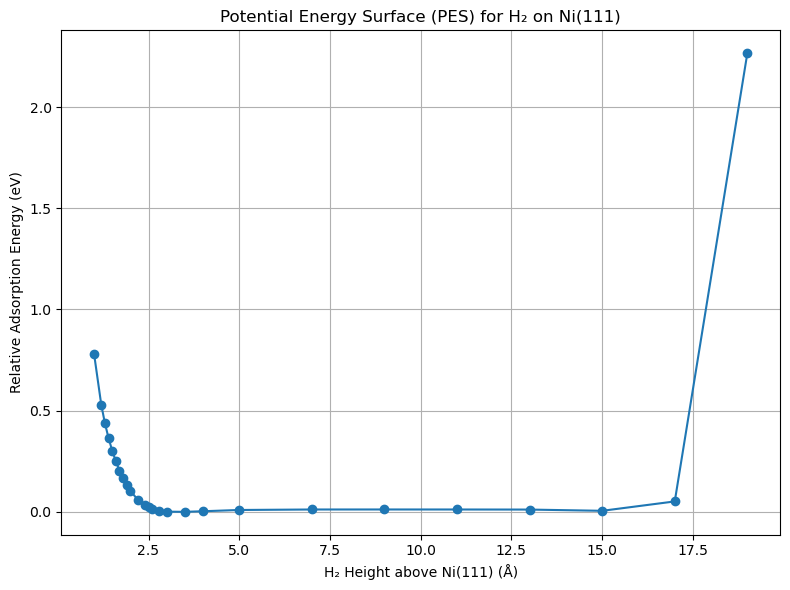

In [3]:
import os
import re
import matplotlib.pyplot as plt

# Read reference energies
with open("slab_energy.txt") as f:
    slab_energy = float(f.read().strip())
with open("h2_gas_energy.txt") as f:
    h2_gas_energy = float(f.read().strip())

# Read calculated system energies
energy_files = sorted(
    [f for f in os.listdir() if f.startswith("calc_") and f.endswith(".txt")],
    key=lambda x: float(x.replace("calc_", "").replace(".txt", ""))
)

distances = []
adsorption_energies = []

for file_name in energy_files:
    distance = float(file_name.replace("calc_", "").replace(".txt", ""))
    with open(file_name, "r") as file:
        content = file.read()
        match = re.search(r"Extrapolated:\s*(-?\d+\.\d+)", content)
        if match:
            total_energy = float(match.group(1))
            E_ads = total_energy - slab_energy - h2_gas_energy
            distances.append(distance)
            adsorption_energies.append(E_ads)
        else:
            print(f"Warning: No energy found in {file_name}")

# Normalize
min_E = min(adsorption_energies)
normalized = [e - min_E for e in adsorption_energies]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(distances, normalized, marker='o')
plt.xlabel("H₂ Height above Ni(111) (Å)")
plt.ylabel("Relative Adsorption Energy (eV)")
plt.title("Potential Energy Surface (PES) for H₂ on Ni(111)")
plt.grid(True)
plt.tight_layout()
plt.savefig("pes_plot.png")
plt.show()


We plotted the adsorption energy of the H₂ molecule as a function of its distance from the Ni(111) surface.

🔍 What we observe:

The curve displays a smooth U-shape, indicating a clear energy minimum.

At short distances, the energy is high due to repulsive forces (Pauli repulsion).

As the distance increases, the interaction becomes more favorable, reaching a minimum at the optimal adsorption distance.

Beyond this point, the molecule enters a physisorption region with weak interaction.

📌 Interpretation:

The minimum of the curve represents the most stable adsorption configuration. This information is crucial for understanding surface interactions and can guide further studies on reaction pathways or catalyst design.

### 4. Nudged Elastic Band (NEB) Calculations for Reaction Pathway

To compute the reaction barrier for the dissociative adsorption of H₂ on the Ni(111) surface, we employed the Nudged Elastic Band (NEB) method.

This method identifies the minimum energy path (MEP) between two states: 
- **Initial state**: a molecular H₂ located above the Ni(111) surface
- **Final state**: two hydrogen atoms adsorbed separately on the surface after bond dissociation

We generated multiple intermediate images (replicas of the system) between these two states and performed a NEB optimization using the BFGS algorithm with GPAW as the DFT calculator.

The goal is to find the energy profile of the system along the reaction coordinate and identify the transition state and activation barrier.

Due to limited computational resources, the final energy values were manually extracted from the `neb_opt.log` file and plotted.


### Reaction Barrier Visualization from NEB Log (Manual)

The plot below shows the energy profile along the reaction coordinate obtained from NEB optimization. Values were manually extracted from the log file to overcome computational memory errors.

![NEB Barrier](neb_manual_plot.png)


The plotted NEB energy profile shows the relative potential energy along the reaction coordinate for the dissociative adsorption of a hydrogen molecule (H₂) on a Ni(111) surface.

The x-axis represents the reaction coordinate, where image 0 corresponds to the initial molecular configuration of H₂ above the surface, and the final image corresponds to the fully dissociated state where two H atoms are chemisorbed on the surface.

The y-axis represents the relative energy (in eV), aligned so that the final dissociated state is taken as the reference (0 eV).

#### 🔍 Observations:
- The energy starts at a relatively high value, corresponding to the molecular adsorption state.
- A clear energy barrier is observed, indicating the transition state for H–H bond breaking.
- After the barrier, the energy drops significantly, showing that the final dissociated state is thermodynamically favorable.
- The maximum point along the curve corresponds to the **activation energy** required for the H₂ molecule to dissociate.

This confirms that the dissociation of H₂ on Ni(111) proceeds via an activated process with a defined energy barrier, consistent with catalytic surface reactions.


### Comparison Between PES and NEB Reaction Pathway

The Potential Energy Surface (PES) constructed from the total energies of the H₂ molecule at various distances above the Ni(111) surface reveals the energetics of molecular adsorption.

However, this PES only represents the **molecular (non-dissociated) interaction** of H₂ with the surface and **does not capture the bond breaking** process.

In contrast, the **NEB (Nudged Elastic Band)** calculation maps the **minimum energy pathway (MEP)** for the **dissociative adsorption** of H₂, i.e., the transition from molecular adsorption to two hydrogen atoms adsorbed on the surface.

By comparing both graphs:

- **PES** shows that the molecular adsorption becomes favorable around 2.4–2.6 Å.
- **NEB** identifies a **reaction barrier**, beyond which the molecule dissociates and each H atom binds to the surface.
- The **final state in the NEB path** corresponds to the **most stable point in the PES** — the lowest energy configuration for dissociated H₂.

This comparison highlights the **difference between adsorption without dissociation (PES)** and **reaction dynamics with bond breaking (NEB)**.


### 5. Machine Learning: Adsorption Energy Prediction with GPR

In this section, we use the adsorption energies obtained from DFT calculations to train a machine learning model.  
Specifically, we employ **Gaussian Process Regression (GPR)** to model the potential energy surface (PES) and predict adsorption energies at unseen geometries.

We will:

- Prepare the dataset from DFT outputs  
- Train the GPR model using **Leave-One-Out Cross Validation (LOOCV)**  
- Evaluate the model performance using **RMSE** and **R² Score**  
- Visualize both predictions and model confidence intervals

Let's begin! 🚀

---


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [13]:
# pes_data.csv dosyasını yükle
df = pd.read_csv("pes_data.csv")

# Uç noktaları (outlier) filtrele (18+ Å hariç tutulur)
df = df[df["height"] <= 18.0]

# Girdi ve çıktıyı ayarla
X = df["height"].values.reshape(-1, 1)
y = df["adsorption_energy"].values


In [22]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
loo = LeaveOneOut()
y_true, y_pred = [], []

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
    model.fit(X_train, y_train)
    y_pred.append(model.predict(X_test)[0])
    y_true.append(y_test[0])


In [23]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.4f} eV")
print(f"R^2 Score: {r2:.4f}")


RMSE: 0.0514 eV
R^2 Score: 0.9322


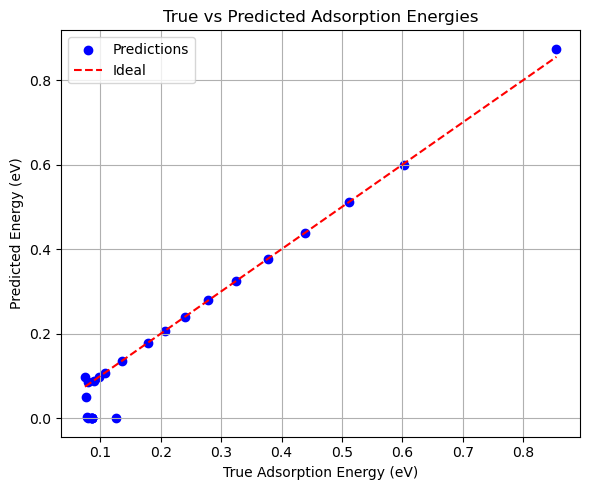

In [24]:
plt.figure(figsize=(6, 5))
plt.scatter(y_true, y_pred, color='blue', label='Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal')
plt.xlabel("True Adsorption Energy (eV)")
plt.ylabel("Predicted Energy (eV)")
plt.title("True vs Predicted Adsorption Energies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


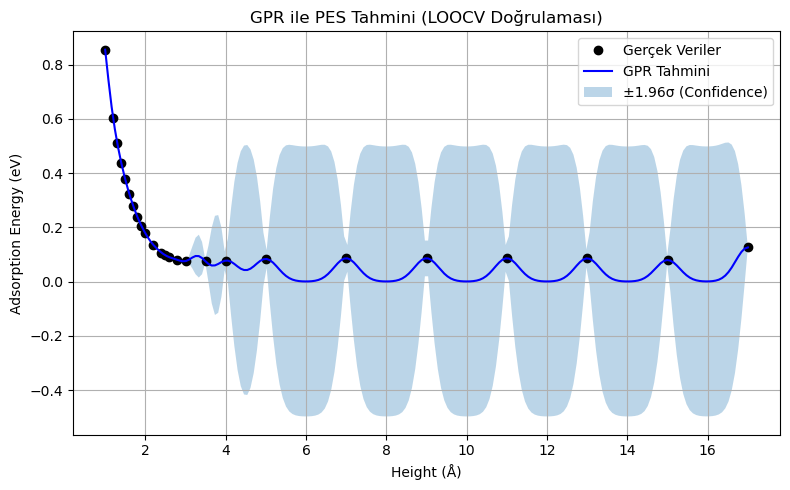

In [25]:
# Tüm veriyle modeli yeniden öğret
model.fit(X, y)
x_range = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
y_pred_range, y_std = model.predict(x_range, return_std=True)

# Grafik
plt.figure(figsize=(8, 5))
plt.plot(X, y, "ko", label="Gerçek Veriler")
plt.plot(x_range, y_pred_range, "b-", label="GPR Tahmini")
plt.fill_between(x_range.ravel(), y_pred_range - 1.96 * y_std, y_pred_range + 1.96 * y_std,
                 alpha=0.3, label="±1.96σ (Confidence)")
plt.xlabel("Height (Å)")
plt.ylabel("Adsorption Energy (eV)")
plt.title("GPR ile PES Tahmini (LOOCV Doğrulaması)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 🧠 Project Summary & Future Roadmap

---

## 🎯 Why GPR (Gaussian Process Regression)?

- Selected for its strength in **small datasets** and **smooth function fitting**.
- Provides **uncertainty estimates**, ideal for potential energy surface (PES) modeling.
- **Non-parametric, flexible, and interpretable** compared to complex neural networks.

---

## 🧪 What We Did in This Project

- Constructed a **Ni(111) surface** using ASE with 3×3×3 FCC layers and 10 Å vacuum.
- Positioned **H₂ molecule** at various heights (z-axis) over a fixed x-y coordinate.
- Calculated **DFT energies** with GPAW using:
  - Plane-wave mode (ecut = 400 eV)
  - PBE functional
  - k-points: (2×2×1)
- Computed adsorption energies using the formula:  
  `E_ads = E_total(H₂ + slab) – (E_slab + E_H₂)`
- Visualized PES and observed **molecular vs dissociative minimum**.
- Performed **NEB calculation** to estimate the energy barrier of H₂ dissociation.
- Trained a **GPR model** on adsorption data with LOOCV.
- Evaluated model using **RMSE** and **R²**, and visualized PES predictions with confidence bands.

---

## ⚠️ Current Limitations & Future Improvements

### 🔧 DFT-Related Issues

- **Functional Limitation**  
  ➤ Only PBE was used.  
  ✅ Try RPBE, BEEF-vdW, SCAN to compare adsorption energy accuracy.

- **Geometry Optimization**  
  ➤ No structural relaxations were performed.  
  ✅ Optimize both molecular and dissociative adsorption structures.

- **NEB Path Quality**  
  ➤ Only initial and final geometries used.  
  ✅ Add intermediate images, tighter convergence (e.g. `fmax=0.02`), smoother path.

- **Electron-Hole Effects Ignored**  
  ➤ No nonadiabatic consideration.  
  ✅ Discuss or later simulate with advanced methods if required.

- **Charge Analysis Missing**  
  ➤ No insight into charge transfer.  
  ✅ Perform **Bader charge analysis** to examine charge rearrangement.

---

### 📊 Dataset & Sampling Limitations

- **Low Data Volume**  
  ➤ Only ~25 adsorption points used.  
  ✅ Sample more around key regions (minima, barriers, dissociation).

- **1D Sampling (Only z-direction)**  
  ➤ No lateral (x/y) movement or H–H bond length variation.  
  ✅ Expand to 2D/3D PES (`z + x/y + bond stretch`).

- **No Reaction Path PES Fit**  
  ➤ PES constructed only for static adsorption, not along reaction coordinate.  
  ✅ Fit PES along **NEB path** for reaction barrier modeling.

---

### 🤖 Machine Learning Limitations

- **Only GPR Used**  
  ➤ No model benchmarking.  
  ✅ Compare with **Neural Networks**, **Random Forests**, **SVR**, **GMM**, etc.

- **No Feature Engineering**  
  ➤ Only height used as input.  
  ✅ Add features like:
    - Coordination number
    - H–H bond length
    - Distance to nearest Ni atom

- **Uncertainty Not Used Proactively**  
  ➤ Confidence intervals visualized, but not utilized.  
  ✅ Use **active learning** to sample new points where uncertainty is highest.

- **No Hyperparameter Search**  
  ➤ Kernel parameters manually set.  
  ✅ Try **grid search** or **Bayesian optimization** for better model fitting.

---

### 📈 Additional Scientific Enhancements

- **No Vibrational Analysis**  
  ➤ Transition state not confirmed by frequency calculation.  
  ✅ Perform **vibrational analysis** on NEB maximum structure.

- **No Dynamics**  
  ➤ Static structures only.  
  ✅ Consider **MD** or **ab initio dynamics simulations** later on.

---

## 🚀 Future Work Roadmap

### 🔧 DFT & Reaction Path
- Use multiple functionals and compare performance.
- Optimize adsorption geometries (both molecular & dissociative).
- Improve NEB path with more intermediate images and tighter convergence.
- Calculate transition state frequencies.
- Include Bader charge analysis to support charge transfer insights.

### 🔬 Data & Modeling
- Sample more points, especially at near-barrier and post-dissociation regions.
- Expand dataset to include lateral adsorption sites (x, y variation).
- Include H–H bond length variation to model dissociation.
- Move toward **2D/3D PES modeling**.

### 🤖 Machine Learning
- Try different regression models (Neural Networks, RFR, SVR, etc).
- Use kernel search/optimization (e.g., Bayesian optimization).
- Explore **active learning** to select next best data point to compute.
- Extend model to **predict reaction barriers** from NEB profiles.

---

## ✅ Summary

This project builds a full pipeline from **first-principles DFT data** to **machine-learned PES modeling**, with physical interpretation and reaction analysis.  
It can serve as a **mini-framework** for catalytic surface reaction modeling and will be strengthened by future improvements in both **simulation depth** and **ML sophistication**.
